# **P. aeruginosa**

# **Initialization**
- These 3 lines of code helps to prevent any problems while reloading and reworking on the same Project. And the third line of code helps to make visualization within the Notebook.

In [1]:
#@ Initialization:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# **Import Libraries**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier  
from sklearn.inspection import plot_partial_dependence, partial_dependence

# **Retrieving the Data**

In [3]:
# GitHub URL
github_url = "https://raw.githubusercontent.com/chaninlab/hdp-antimicrobial-selectivity/master/Paeruginosa_desc_from_1st_run_master.csv"

# Loading the Data:
def load_data(PATH=github_url):
  csv_path = os.path.join(PATH)
  return pd.read_csv(csv_path)

bacteria = load_data()

# **Displaying the dataset**

In [4]:
bacteria.head(7)

,Isoelectric,Mass,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y,Composition of Hydrophobicity(1),Composition of Hydrophobicity(2),Composition of Hydrophobicity(3),Composition of Normalized vdW volumes(1),Composition of Normalized vdW volumes(2),Composition of Normalized vdW volumes(3),Composition of Polarity(1),Composition of Polarity(2),Composition of Polarity(3),Composition of Polarizability(1),Composition of Polarizability(2),Composition of Polarizability(3),Composition of Charge(1),Composition of Charge(2),Composition of Charge(3),Composition of Secondary structure(1),Composition of Secondary structure(2),Composition of Secondary structure(3),...,Distribution of No. of hydrogen bond donor in side chain(7),Distribution of No. of hydrogen bond donor in side chain(8),Distribution of No. of hydrogen bond donor in side chain(9),Distribution of No. of hydrogen bond donor in side chain(10),Distribution of No. of hydrogen bond donor in side chain(11),Distribution of No. of hydrogen bond donor in side chain(12),Distribution of No. of hydrogen bond donor in side chain(13),Distribution of No. of hydrogen bond donor in side chain(14),Distribution of No. of hydrogen bond donor in side chain(15),Distribution of No. of hydrogen bond acceptor in side chain(1),Distribution of No. of hydrogen bond acceptor in side chain(2),Distribution of No. of hydrogen bond acceptor in side chain(3),Distribution of No. of hydrogen bond acceptor in side chain(4),Distribution of No. of hydrogen bond acceptor in side chain(5),Distribution of No. of hydrogen bond acceptor in side chain(6),Distribution of No. of hydrogen bond acceptor in side chain(7),Distribution of No. of hydrogen bond acceptor in side chain(8),Distribution of No. of hydrogen bond acceptor in side chain(9),Distribution of No. of hydrogen bond acceptor in side chain(10),Distribution of No. of hydrogen bond acceptor in side chain(11),Distribution of No. of hydrogen bond acceptor in side chain(12),Distribution of No. of hydrogen bond acceptor in side chain(13),Distribution of No. of hydrogen bond acceptor in side chain(14),Distribution of No. of hydrogen bond acceptor in side chain(15),Distribution of CLogP(1),Distribution of CLogP(2),Distribution of CLogP(3),Distribution of CLogP(4),Distribution of CLogP(5),Distribution of CLogP(6),Distribution of CLogP(7),Distribution of CLogP(8),Distribution of CLogP(9),Distribution of CLogP(10),Distribution of CLogP(11),Distribution of CLogP(12),Distribution of CLogP(13),Distribution of CLogP(14),Distribution of CLogP(15),Activity
0,11.79,2372.86,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,25.000000,0.0,0.0,0.0,0.000000,50.000000,0.0,0.000000,0.000000,0.000000,25.000000,50.000000,25.000000,25.000000,0.000000,25.000000,75.000000,50.000000,0.000000,50.000000,0.000000,25.000000,75.000000,50.000000,50.000000,0.000000,75.000000,25.000000,0.000000,...,50.000000,43.750000,37.500000,75.000000,68.750000,62.500000,100.000000,93.750000,87.500000,6.250000,18.750000,12.500000,25.000000,18.750000,12.500000,50.000000,43.750000,37.500000,75.000000,68.750000,62.500000,100.000000,93.750000,87.500000,6.250000,18.750000,12.500000,25.000000,18.750000,12.500000,50.000000,43.750000,37.500000,75.000000,68.750000,62.500000,100.000000,93.750000,87.500000,High
1,11.55,1195.44,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,25.000000,0.0,0.0,0.0,0.000000,50.000000,0.0,0.000000,0.000000,0.000000,25.000000,50.000000,25.000000,25.000000,0.000000,25.000000,75.000000,50.000000,0.000000,50.000000,0.000000,25.000000,75.000000,50.000000,50.000000,0.000000,75.000000,25.000000,0.000000,...,50.000000,37.500000,25.000000,62.500000,37.500000,25.000000,100.000000,87.500000,75.000000,12.500000,37.500000,25.000000,12.500000,37.500000,25.000000,50.000000,37.500000,25.000000,62.500000,37.500000,25.000000,100.000000,87.500000,75.000000,12.500000,37.500000,25.000000,12.500000,37.500000,25.000000,50.000000,37.500000,25.000000,62.500000,37.500000,25.000000,100.000000

In [5]:
bacteria["Activity"] = bacteria["Activity"].map({"High": 1, "Low": 0})
bacteria.head(7)

,Isoelectric,Mass,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y,Composition of Hydrophobicity(1),Composition of Hydrophobicity(2),Composition of Hydrophobicity(3),Composition of Normalized vdW volumes(1),Composition of Normalized vdW volumes(2),Composition of Normalized vdW volumes(3),Composition of Polarity(1),Composition of Polarity(2),Composition of Polarity(3),Composition of Polarizability(1),Composition of Polarizability(2),Composition of Polarizability(3),Composition of Charge(1),Composition of Charge(2),Composition of Charge(3),Composition of Secondary structure(1),Composition of Secondary structure(2),Composition of Secondary structure(3),...,Distribution of No. of hydrogen bond donor in side chain(7),Distribution of No. of hydrogen bond donor in side chain(8),Distribution of No. of hydrogen bond donor in side chain(9),Distribution of No. of hydrogen bond donor in side chain(10),Distribution of No. of hydrogen bond donor in side chain(11),Distribution of No. of hydrogen bond donor in side chain(12),Distribution of No. of hydrogen bond donor in side chain(13),Distribution of No. of hydrogen bond donor in side chain(14),Distribution of No. of hydrogen bond donor in side chain(15),Distribution of No. of hydrogen bond acceptor in side chain(1),Distribution of No. of hydrogen bond acceptor in side chain(2),Distribution of No. of hydrogen bond acceptor in side chain(3),Distribution of No. of hydrogen bond acceptor in side chain(4),Distribution of No. of hydrogen bond acceptor in side chain(5),Distribution of No. of hydrogen bond acceptor in side chain(6),Distribution of No. of hydrogen bond acceptor in side chain(7),Distribution of No. of hydrogen bond acceptor in side chain(8),Distribution of No. of hydrogen bond acceptor in side chain(9),Distribution of No. of hydrogen bond acceptor in side chain(10),Distribution of No. of hydrogen bond acceptor in side chain(11),Distribution of No. of hydrogen bond acceptor in side chain(12),Distribution of No. of hydrogen bond acceptor in side chain(13),Distribution of No. of hydrogen bond acceptor in side chain(14),Distribution of No. of hydrogen bond acceptor in side chain(15),Distribution of CLogP(1),Distribution of CLogP(2),Distribution of CLogP(3),Distribution of CLogP(4),Distribution of CLogP(5),Distribution of CLogP(6),Distribution of CLogP(7),Distribution of CLogP(8),Distribution of CLogP(9),Distribution of CLogP(10),Distribution of CLogP(11),Distribution of CLogP(12),Distribution of CLogP(13),Distribution of CLogP(14),Distribution of CLogP(15),Activity
0,11.79,2372.86,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,25.000000,0.0,0.0,0.0,0.000000,50.000000,0.0,0.000000,0.000000,0.000000,25.000000,50.000000,25.000000,25.000000,0.000000,25.000000,75.000000,50.000000,0.000000,50.000000,0.000000,25.000000,75.000000,50.000000,50.000000,0.000000,75.000000,25.000000,0.000000,...,50.000000,43.750000,37.500000,75.000000,68.750000,62.500000,100.000000,93.750000,87.500000,6.250000,18.750000,12.500000,25.000000,18.750000,12.500000,50.000000,43.750000,37.500000,75.000000,68.750000,62.500000,100.000000,93.750000,87.500000,6.250000,18.750000,12.500000,25.000000,18.750000,12.500000,50.000000,43.750000,37.500000,75.000000,68.750000,62.500000,100.000000,93.750000,87.500000,1
1,11.55,1195.44,0.000000,0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,25.000000,0.0,0.0,0.0,0.000000,50.000000,0.0,0.000000,0.000000,0.000000,25.000000,50.000000,25.000000,25.000000,0.000000,25.000000,75.000000,50.000000,0.000000,50.000000,0.000000,25.000000,75.000000,50.000000,50.000000,0.000000,75.000000,25.000000,0.000000,...,50.000000,37.500000,25.000000,62.500000,37.500000,25.000000,100.000000,87.500000,75.000000,12.500000,37.500000,25.000000,12.500000,37.500000,25.000000,50.000000,37.500000,25.000000,62.500000,37.500000,25.000000,100.000000,87.500000,75.000000,12.500000,37.500000,25.000000,12.500000,37.500000,25.000000,50.000000,37.500000,25.000000,62.500000,37.500000,25.000000,100.000000,87

---

# **Determining the Top 20 features**

The top 20 features are deduced from the mean of the Gini score from 25 runs.



In [6]:
gini_score = pd.read_csv('https://raw.githubusercontent.com/chaninlab/hdp-antimicrobial-selectivity/master/Paeruginosa_gini_importance_nestimator100.csv')
gini_score

,Columns,Run123,Run124,Run125,Run126,Run127,Run128,Run129,Run130,Run131,Run132,Run133,Run134,Run135,Run136,Run137,Run138,Run139,Run140,Run141,Run142,Run143,Run144,Run145,Run146,Run147,Average,SD
0,Composition of No. of hydrogen bond donor in s...,0.076816,0.042829,0.039249,0.058377,0.018122,0.032533,0.063651,0.037357,0.072949,0.037557,0.035297,0.062319,0.040540,0.058912,0.062552,0.048860,0.045524,0.068938,0.039122,0.059367,0.045138,0.043991,0.075516,0.030265,0.036342,0.049285,0.015310
1,Composition of No. of hydrogen bond acceptor i...,0.041162,0.049192,0.038669,0.049971,0.066671,0.038172,0.034424,0.074521,0.038999,0.060238,0.040344,0.039187,0.035705,0.019579,0.042181,0.038910,0.042132,0.027750,0.026277,0.019036,0.026167,0.054700,0.046221,0.051692,0.065854,0.042710,0.013896
2,Composition of No. of hydrogen bond donor in s...,0.041450,0.045609,0.053939,0.034328,0.026449,0.030902,0.051676,0.037601,0.031421,0.055555,0.039215,0.067057,0.041312,0.047559,0.031867,0.043372,0.024201,0.039873,0.026851,0.056057,0.044885,0.034808,0.033211,0.025450,0.043666,0.040333,0.010682
3,Composition of Solvent accessibility(1),0.043992,0.047513,0.053374,0.019725,0.026154,0.022280,0.045035,0.025449,0.027026,0.040986,0.018129,0.063642,0.024330,0.026899,0.030963,0.039225,0.031072,0.032074,0.037528,0.035138,0.032338,0.032301,0.030773,0.040415,0.058784,0.035406,0.011510
4,Composition of Polarity(3),0.049197,0.060601,0.034719,0.026934,0.039439,0.044005,0.027091,0.053321,0.020199,0.034624,0.058638,0.015531,0.047715,0.025392,0.020062,0.037606,0.031266,0.029129,0.054220,0.053820,0.029413,0.024154,0.024859,0.019992,0.020408,0.035293,0.013449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,Distribution of Polarity(13),0.000000,0.000000,0.000000,0.000000,0.000000,0.002254,0.000000,0.001300,0.000308,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000310,0.000000,0.000000,0.000000,0.001171,0.000000,0.000000,0.000595,0.000000,0.000237,0.000539
249,Distribution of Hydrophobicity(15),0.000929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000929,0.000000,0.000845,0.000000,0.000000,0.000000,0.000427,0.000000,0.000000,0.000000,0.000000,0.000000,0.001463,0.000000,0.000000,0.000000,0.000462,0.000000,0.000202,0.000398
250,Q,0.000000,0.000000,0.000000,0.001154,0.000000,0.000000,0.000879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000539,0.000000,0.000000,0.000291,0.000000,0.000000,0.000982,0.000591,0.000177,0.000347
251,P,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001148,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000463,0.000000,0.000000,0.000000,0.000000,0.000064,0.000239


In [7]:
top20gini = gini_score['Columns'][:20]
top20gini

0     Composition of No. of hydrogen bond donor in s...
1     Composition of No. of hydrogen bond acceptor i...
2     Composition of No. of hydrogen bond donor in s...
3               Composition of Solvent accessibility(1)
4                            Composition of Polarity(3)
5                               Composition of CLogP(1)
6                                           Isoelectric
7     Transition of No. of hydrogen bond donor in si...
8              Composition of Normalized vdW volumes(3)
9                      Composition of Polarizability(3)
10              Composition of Solvent accessibility(2)
11                              Transition of Charge(1)
12                     Composition of Hydrophobicity(1)
13            Distribution of Normalized vdW volumes(6)
14                    Distribution of Polarizability(6)
15                             Composition of Charge(1)
16                                                    L
17               Distribution of Secondary struc

---

# **Calculate Partial Dependence PDP values**

**Custom function for Calculating Partial Dependence**

In [8]:
def pdp(feature_name, grid):
  pdp_Y, pdp_X = partial_dependence(model, features=feature_name, X=data, grid_resolution=grid)

  Y = pd.DataFrame(np.transpose(pdp_Y))
  X = pd.DataFrame(np.transpose(pdp_X))

  df = pd.concat( [X,Y], axis=1 )
  df.columns = [feature_name, str('Partial_Dependence_') + feature_name]
  return df

**Test the custom function on the first element from the top 20 features**

In [9]:
# pdp(feature_name=top20gini[0], grid=10)

**Apply the pdp function on the entire list of top 20 features**

In [10]:
#list_feature = {}
#list_partial_dependence = {}

#for feature in top20gini:
#  a = pdp(feature_name=feature, grid=10)
#  list_partial_dependence[ feature ] = a.iloc[:,1] # Y
#  list_feature[ feature ] = a.iloc[:,0] # X

**Displaying the calculated PDP values**

Feature (X axis)

In [11]:
#df_feature = pd.DataFrame.from_dict(list_feature, orient="columns")
#df_feature

Partial dependence score (Y axis)

In [12]:
#df_partial_dependence = pd.DataFrame.from_dict(list_partial_dependence, orient="columns")
#df_partial_dependence

---

# **Model Building**

### **Preparing DataFrame for Model Building**

In [13]:
data = bacteria.drop("Activity", axis=1) # Dropping the Labels from Training set.
activity = bacteria["Activity"].copy()   # Target Attributes.

### **Y-scrambling (Shuffling the Activity column)**

In [14]:
activity

0     1
1     1
2     1
3     1
4     1
     ..
60    0
61    0
62    0
63    0
64    0
Name: Activity, Length: 65, dtype: int64

In [15]:
from numpy.random import permutation
perm = permutation(len(activity))
activity_shuffled = activity[perm]

In [16]:
activity_shuffled

28    1
60    0
9     1
1     1
51    0
     ..
37    0
33    1
38    0
36    0
54    0
Name: Activity, Length: 65, dtype: int64

### **Building the Random Forest Model**

In [17]:
model = RandomForestClassifier(random_state=123).fit(data, activity)              

### **Create a Dictionary containing DataFrames for all 25 runs**

In [18]:
from numpy.random import permutation

list_feature = {}
list_partial_dependence = {}

df1 = {}
df2 = {}

for seed in range(123, 148):
  perm = permutation(len(activity))
  activity_shuffled = activity[perm]
  model = RandomForestClassifier(random_state=seed).fit(data, activity_shuffled)
  for feature in top20gini:
    a = pdp(feature_name=feature, grid=10)
    list_partial_dependence[ feature ] = a.iloc[:,1] # Y
    list_feature[ feature ] = a.iloc[:,0] # X

    df_feature = pd.DataFrame.from_dict(list_feature, orient="columns")
    df_partial_dependence = pd.DataFrame.from_dict(list_partial_dependence, orient="columns")

    df1[seed] = df_feature
    df2[seed] = df_partial_dependence

Here, we are going to consolidate the 25 DataFrame names (e.g. df1[123] from calculation run using seed of 123) as a single list

In [19]:
list_df1 = []
for i in df1:
  a = 'df1[' + str(i) +']'
  list_df1.append(a)
list_df1 = ', '.join(list_df1)

In [20]:
list_df2 = []
for i in df2:
  a = 'df2[' + str(i) +']'
  list_df2.append(a)
list_df2 = ', '.join(list_df2)

Here, we are going to combine all 25 DataFrames into a single DataFrame where they are essentially vertically stacked on top of one another (i.e. such that the number of column remains the same while the number of rows expands to the consolidated sum of all rows of all 25 DataFrames).

In [21]:
df_X = pd.concat( eval(list_df1), axis=0)
df_X

,Composition of No. of hydrogen bond donor in side chain(1),Composition of No. of hydrogen bond acceptor in side chain(3),Composition of No. of hydrogen bond donor in side chain(3),Composition of Solvent accessibility(1),Composition of Polarity(3),Composition of CLogP(1),Isoelectric,Transition of No. of hydrogen bond donor in side chain(1),Composition of Normalized vdW volumes(3),Composition of Polarizability(3),Composition of Solvent accessibility(2),Transition of Charge(1),Composition of Hydrophobicity(1),Distribution of Normalized vdW volumes(6),Distribution of Polarizability(6),Composition of Charge(1),L,Distribution of Secondary structure(5),Composition of No. of hydrogen bond acceptor in side chain(1),Composition of Charge(2)
0,11.002801,23.076923,23.076923,44.444444,11.002801,11.002801,8.750000,0.000000,12.500000,12.500000,7.692308,13.333333,7.692308,5.555556,5.555556,6.250000,4.416667,5.555556,0.000000,52.538462
1,15.335823,29.597477,29.597477,47.999457,15.335823,15.335823,9.164444,5.555556,19.658120,19.658120,12.393163,18.432244,12.393163,11.222002,11.222002,10.829060,8.128918,11.111112,4.569024,57.117521
2,19.668846,36.118030,36.118030,51.554470,19.668846,19.668846,9.578889,11.111111,26.816239,26.816239,17.094017,23.531154,17.094017,16.888448,16.888448,15.408120,11.841168,16.666667,9.138047,61.696581
3,24.001868,42.638584,42.638584,55.109483,24.001868,24.001868,9.993333,16.666667,33.974359,33.974359,21.794872,28.630065,21.794872,22.554894,22.554894,19.987179,15.553419,22.222223,13.707071,66.275641
4,28.334890,49.159137,49.159137,58.664496,28.334890,28.334890,10.407778,22.222222,41.132479,41.132479,26.495727,33.728976,26.495727,28.221341,28.221341,24.566239,19.265670,27.777778,18.276094,70.854701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,32.667912,55.679691,55.679691,62.219509,32.667912,32.667912,10.822222,27.777778,48.290598,48.290598,31.196581,38.827886,31.196581,33.887787,33.887787,29.145299,22.977920,33.333334,22.845118,75.433761
6,37.000934,62.200244,62.200244,65.774522,37.000934,37.000934,11.236667,33.333333,55.448718,55.448718,35.897436,43.926797,35.897436,39.554233,39.554233,33.724359,26.690171,38.888889,27.414141,80.012821
7,41.333956,68.720798,68.720798,69.329534,41.333956,41.333956,11.651111,38.888889,62.606838,62.606838,40.598291,49.025708,40.598291,45.220679,45.220679,38.303419,30.402422,44.444445,31.983165,84.591880
8,45.666978,75.241351,75.241351,72.884547,45.666978,45.666978,12.065556,44.444444,69.764957,69.764957,45.299145,54.124618,45.299145,50.887125,50.887125,42.882479,34.114672,50.000000,36.552188,89.170940


In [22]:
df_Y = pd.concat( eval(list_df2), axis=0)
df_Y

,Composition of No. of hydrogen bond donor in side chain(1),Composition of No. of hydrogen bond acceptor in side chain(3),Composition of No. of hydrogen bond donor in side chain(3),Composition of Solvent accessibility(1),Composition of Polarity(3),Composition of CLogP(1),Isoelectric,Transition of No. of hydrogen bond donor in side chain(1),Composition of Normalized vdW volumes(3),Composition of Polarizability(3),Composition of Solvent accessibility(2),Transition of Charge(1),Composition of Hydrophobicity(1),Distribution of Normalized vdW volumes(6),Distribution of Polarizability(6),Composition of Charge(1),L,Distribution of Secondary structure(5),Composition of No. of hydrogen bond acceptor in side chain(1),Composition of Charge(2)
0,0.542462,0.538923,0.537385,0.529538,0.538769,0.538923,0.543846,0.540308,0.532769,0.518308,0.539077,0.539231,0.527538,0.537846,0.542769,0.543692,0.545692,0.536308,0.539846,0.536000
1,0.542000,0.536769,0.539231,0.529538,0.538769,0.538923,0.543846,0.540769,0.535077,0.518308,0.542462,0.539231,0.537077,0.541385,0.542769,0.540462,0.541846,0.540462,0.541231,0.536000
2,0.542000,0.534462,0.539231,0.529538,0.538769,0.538923,0.543846,0.543231,0.544769,0.546923,0.542462,0.539231,0.542923,0.541231,0.539231,0.540462,0.541846,0.540462,0.539385,0.536000
3,0.542000,0.538154,0.541385,0.548000,0.542308,0.542769,0.543846,0.543538,0.545385,0.547538,0.542462,0.540462,0.542923,0.541231,0.539231,0.540462,0.541846,0.540462,0.538923,0.540154
4,0.542000,0.541692,0.541385,0.545231,0.542308,0.542769,0.543846,0.542000,0.545385,0.547538,0.542462,0.540462,0.542923,0.541231,0.538615,0.540462,0.541846,0.540462,0.541077,0.542462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,0.543077,0.544615,0.545385,0.544462,0.547692,0.547231,0.544769,0.542923,0.548000,0.548000,0.545231,0.546769,0.543385,0.540462,0.540000,0.544308,0.546615,0.543385,0.542615,0.546615
6,0.538000,0.546154,0.547231,0.544462,0.548462,0.547538,0.544769,0.542923,0.548615,0.550154,0.545231,0.545538,0.543385,0.541846,0.540000,0.543692,0.543846,0.543385,0.542615,0.546615
7,0.537231,0.546154,0.544154,0.544462,0.540154,0.538000,0.544769,0.542923,0.548615,0.551538,0.543846,0.543846,0.540000,0.541846,0.540000,0.543692,0.543846,0.543385,0.542615,0.546615
8,0.535231,0.546154,0.544154,0.544462,0.537385,0.538000,0.544154,0.544462,0.548615,0.551538,0.544000,0.543846,0.540000,0.539077,0.540000,0.543692,0.543846,0.543385,0.544462,0.546615


Now, we are going to group by the index such that rows with index number of 0 will be grouped together. Subsequently, we will calculate the mean and standard deviation values of the 25 runs.

In [23]:
X_mean = df_X.groupby(df_X.index).mean()
X_mean

,Composition of No. of hydrogen bond donor in side chain(1),Composition of No. of hydrogen bond acceptor in side chain(3),Composition of No. of hydrogen bond donor in side chain(3),Composition of Solvent accessibility(1),Composition of Polarity(3),Composition of CLogP(1),Isoelectric,Transition of No. of hydrogen bond donor in side chain(1),Composition of Normalized vdW volumes(3),Composition of Polarizability(3),Composition of Solvent accessibility(2),Transition of Charge(1),Composition of Hydrophobicity(1),Distribution of Normalized vdW volumes(6),Distribution of Polarizability(6),Composition of Charge(1),L,Distribution of Secondary structure(5),Composition of No. of hydrogen bond acceptor in side chain(1),Composition of Charge(2)
0,11.002801,23.076923,23.076923,44.444444,11.002801,11.002801,8.750000,0.000000,12.500000,12.500000,7.692308,13.333333,7.692308,5.555556,5.555556,6.250000,4.416667,5.555556,0.000000,52.538462
1,15.335823,29.597477,29.597477,47.999457,15.335823,15.335823,9.164444,5.555556,19.658120,19.658120,12.393163,18.432244,12.393163,11.222002,11.222002,10.829060,8.128918,11.111112,4.569024,57.117521
2,19.668846,36.118030,36.118030,51.554470,19.668846,19.668846,9.578889,11.111111,26.816239,26.816239,17.094017,23.531154,17.094017,16.888448,16.888448,15.408120,11.841168,16.666667,9.138047,61.696581
3,24.001868,42.638584,42.638584,55.109483,24.001868,24.001868,9.993333,16.666667,33.974359,33.974359,21.794872,28.630065,21.794872,22.554894,22.554894,19.987179,15.553419,22.222223,13.707071,66.275641
4,28.334890,49.159137,49.159137,58.664496,28.334890,28.334890,10.407778,22.222222,41.132479,41.132479,26.495727,33.728976,26.495727,28.221341,28.221341,24.566239,19.265670,27.777778,18.276094,70.854701
5,32.667912,55.679691,55.679691,62.219509,32.667912,32.667912,10.822222,27.777778,48.290598,48.290598,31.196581,38.827886,31.196581,33.887787,33.887787,29.145299,22.977920,33.333334,22.845118,75.433761
6,37.000934,62.200244,62.200244,65.774522,37.000934,37.000934,11.236667,33.333333,55.448718,55.448718,35.897436,43.926797,35.897436,39.554233,39.554233,33.724359,26.690171,38.888889,27.414141,80.012821
7,41.333956,68.720798,68.720798,69.329534,41.333956,41.333956,11.651111,38.888889,62.606838,62.606838,40.598291,49.025708,40.598291,45.220679,45.220679,38.303419,30.402422,44.444445,31.983165,84.591880
8,45.666978,75.241351,75.241351,72.884547,45.666978,45.666978,12.065556,44.444444,69.764957,69.764957,45.299145,54.124618,45.299145,50.887125,50.887125,42.882479,34.114672,50.000000,36.552188,89.170940
9,50.000000,81.761905,81.761905,76.439560,50.000000,50.000000,12.480000,50.000000,76.923077,76.923077,50.000000,59.223529,50.000000,56.553571,56.553571,47.461538,37.826923,55.555556,41.121212,93.750000


In [24]:
X_sd = df_X.groupby(df_X.index).std()
X_sd

,Composition of No. of hydrogen bond donor in side chain(1),Composition of No. of hydrogen bond acceptor in side chain(3),Composition of No. of hydrogen bond donor in side chain(3),Composition of Solvent accessibility(1),Composition of Polarity(3),Composition of CLogP(1),Isoelectric,Transition of No. of hydrogen bond donor in side chain(1),Composition of Normalized vdW volumes(3),Composition of Polarizability(3),Composition of Solvent accessibility(2),Transition of Charge(1),Composition of Hydrophobicity(1),Distribution of Normalized vdW volumes(6),Distribution of Polarizability(6),Composition of Charge(1),L,Distribution of Secondary structure(5),Composition of No. of hydrogen bond acceptor in side chain(1),Composition of Charge(2)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
Y_mean = df_Y.groupby(df_Y.index).mean()
Y_mean

,Composition of No. of hydrogen bond donor in side chain(1),Composition of No. of hydrogen bond acceptor in side chain(3),Composition of No. of hydrogen bond donor in side chain(3),Composition of Solvent accessibility(1),Composition of Polarity(3),Composition of CLogP(1),Isoelectric,Transition of No. of hydrogen bond donor in side chain(1),Composition of Normalized vdW volumes(3),Composition of Polarizability(3),Composition of Solvent accessibility(2),Transition of Charge(1),Composition of Hydrophobicity(1),Distribution of Normalized vdW volumes(6),Distribution of Polarizability(6),Composition of Charge(1),L,Distribution of Secondary structure(5),Composition of No. of hydrogen bond acceptor in side chain(1),Composition of Charge(2)
0,0.549582,0.550948,0.550492,0.549446,0.549114,0.549982,0.549243,0.550837,0.550240,0.549194,0.549329,0.548880,0.547957,0.549717,0.549631,0.550806,0.549717,0.551262,0.550732,0.551052
1,0.550215,0.550449,0.550400,0.549089,0.550326,0.550363,0.549723,0.551034,0.550222,0.549858,0.550258,0.550197,0.549483,0.550548,0.551003,0.550726,0.550265,0.550622,0.550923,0.551698
2,0.550400,0.550394,0.550874,0.549606,0.550603,0.550412,0.550209,0.550689,0.550234,0.551083,0.551391,0.550486,0.550326,0.551329,0.551102,0.550382,0.551163,0.550203,0.551151,0.551588
3,0.550517,0.550462,0.551009,0.551255,0.550431,0.550609,0.551114,0.551009,0.551428,0.551323,0.551286,0.550535,0.550369,0.551298,0.551151,0.551052,0.551268,0.550135,0.551071,0.552080
4,0.550665,0.550382,0.550665,0.551378,0.550431,0.550886,0.551514,0.550308,0.551994,0.551766,0.550455,0.550388,0.550271,0.551249,0.551446,0.551120,0.551415,0.550935,0.552215,0.550597
5,0.551206,0.550425,0.550782,0.551428,0.551372,0.551422,0.550788,0.549735,0.552295,0.552357,0.550486,0.550560,0.550554,0.551280,0.551268,0.550652,0.551458,0.550886,0.552209,0.550271
6,0.551342,0.551071,0.551225,0.551532,0.551588,0.551489,0.551218,0.549662,0.551175,0.551723,0.551058,0.551280,0.552062,0.551526,0.551317,0.550978,0.551071,0.551046,0.552129,0.550542
7,0.551649,0.550978,0.550677,0.551557,0.551748,0.551218,0.551151,0.549711,0.550031,0.551188,0.550628,0.551545,0.551723,0.551231,0.551317,0.550812,0.550898,0.551557,0.551545,0.550222
8,0.551477,0.550935,0.550265,0.551058,0.551348,0.551243,0.551200,0.550055,0.549748,0.551280,0.550646,0.551569,0.551575,0.551120,0.551317,0.551077,0.550400,0.551569,0.551034,0.550683
9,0.551446,0.550535,0.549711,0.550671,0.551317,0.550117,0.549495,0.550068,0.549945,0.550671,0.549440,0.551323,0.550960,0.551120,0.551317,0.551175,0.550271,0.551569,0.550898,0.550646


In [26]:
Y_sd = df_Y.groupby(df_Y.index).std()
Y_sd

,Composition of No. of hydrogen bond donor in side chain(1),Composition of No. of hydrogen bond acceptor in side chain(3),Composition of No. of hydrogen bond donor in side chain(3),Composition of Solvent accessibility(1),Composition of Polarity(3),Composition of CLogP(1),Isoelectric,Transition of No. of hydrogen bond donor in side chain(1),Composition of Normalized vdW volumes(3),Composition of Polarizability(3),Composition of Solvent accessibility(2),Transition of Charge(1),Composition of Hydrophobicity(1),Distribution of Normalized vdW volumes(6),Distribution of Polarizability(6),Composition of Charge(1),L,Distribution of Secondary structure(5),Composition of No. of hydrogen bond acceptor in side chain(1),Composition of Charge(2)
0,0.008674,0.010121,0.010649,0.009174,0.008552,0.008436,0.010062,0.008021,0.009799,0.011282,0.009112,0.008584,0.009250,0.009103,0.007736,0.009045,0.010225,0.009789,0.008679,0.008871
1,0.008621,0.009878,0.010428,0.009075,0.009294,0.008710,0.010118,0.008636,0.009082,0.010755,0.009717,0.008016,0.008795,0.008274,0.007637,0.009090,0.009434,0.007659,0.008573,0.008911
2,0.008304,0.009710,0.009455,0.008651,0.009102,0.008610,0.010104,0.008714,0.007900,0.008454,0.009162,0.008364,0.009021,0.008570,0.008166,0.008938,0.008529,0.007701,0.008797,0.008536
3,0.008489,0.009486,0.009385,0.008846,0.008516,0.008397,0.009259,0.008448,0.007878,0.008301,0.008805,0.008424,0.008901,0.008455,0.008411,0.008399,0.008616,0.007955,0.008735,0.008324
4,0.008484,0.008912,0.008529,0.008599,0.008516,0.008428,0.009168,0.009715,0.008015,0.008162,0.008375,0.007857,0.008972,0.008900,0.009927,0.008650,0.008186,0.008036,0.008960,0.008585
5,0.008595,0.008699,0.008129,0.008469,0.008327,0.008640,0.009760,0.010253,0.007464,0.007425,0.008618,0.008348,0.009072,0.008950,0.010006,0.008419,0.008188,0.008047,0.008961,0.008421
6,0.008986,0.008981,0.008181,0.008267,0.008538,0.008662,0.009660,0.010267,0.007712,0.007815,0.008736,0.008970,0.008886,0.008940,0.010196,0.008424,0.008194,0.008455,0.008810,0.008494
7,0.009527,0.008946,0.008263,0.008931,0.009108,0.008868,0.010178,0.010570,0.008216,0.007751,0.008663,0.008610,0.009476,0.009672,0.010196,0.008781,0.008531,0.009220,0.009517,0.008503
8,0.009124,0.008824,0.007733,0.009920,0.008871,0.008904,0.010003,0.010674,0.008711,0.008061,0.008184,0.009078,0.009591,0.009799,0.010196,0.008245,0.008792,0.010641,0.010111,0.009564
9,0.009558,0.008748,0.007783,0.010349,0.008923,0.009353,0.010645,0.010513,0.009323,0.008663,0.009031,0.009009,0.009196,0.009799,0.010196,0.008385,0.009298,0.010641,0.010336,0.010322


# **Results from individual runs**

In [27]:
df1[123]

,Composition of No. of hydrogen bond donor in side chain(1),Composition of No. of hydrogen bond acceptor in side chain(3),Composition of No. of hydrogen bond donor in side chain(3),Composition of Solvent accessibility(1),Composition of Polarity(3),Composition of CLogP(1),Isoelectric,Transition of No. of hydrogen bond donor in side chain(1),Composition of Normalized vdW volumes(3),Composition of Polarizability(3),Composition of Solvent accessibility(2),Transition of Charge(1),Composition of Hydrophobicity(1),Distribution of Normalized vdW volumes(6),Distribution of Polarizability(6),Composition of Charge(1),L,Distribution of Secondary structure(5),Composition of No. of hydrogen bond acceptor in side chain(1),Composition of Charge(2)
0,11.002801,23.076923,23.076923,44.444444,11.002801,11.002801,8.750000,0.000000,12.500000,12.500000,7.692308,13.333333,7.692308,5.555556,5.555556,6.250000,4.416667,5.555556,0.000000,52.538462
1,15.335823,29.597477,29.597477,47.999457,15.335823,15.335823,9.164444,5.555556,19.658120,19.658120,12.393163,18.432244,12.393163,11.222002,11.222002,10.829060,8.128918,11.111112,4.569024,57.117521
2,19.668846,36.118030,36.118030,51.554470,19.668846,19.668846,9.578889,11.111111,26.816239,26.816239,17.094017,23.531154,17.094017,16.888448,16.888448,15.408120,11.841168,16.666667,9.138047,61.696581
3,24.001868,42.638584,42.638584,55.109483,24.001868,24.001868,9.993333,16.666667,33.974359,33.974359,21.794872,28.630065,21.794872,22.554894,22.554894,19.987179,15.553419,22.222223,13.707071,66.275641
4,28.334890,49.159137,49.159137,58.664496,28.334890,28.334890,10.407778,22.222222,41.132479,41.132479,26.495727,33.728976,26.495727,28.221341,28.221341,24.566239,19.265670,27.777778,18.276094,70.854701
5,32.667912,55.679691,55.679691,62.219509,32.667912,32.667912,10.822222,27.777778,48.290598,48.290598,31.196581,38.827886,31.196581,33.887787,33.887787,29.145299,22.977920,33.333334,22.845118,75.433761
6,37.000934,62.200244,62.200244,65.774522,37.000934,37.000934,11.236667,33.333333,55.448718,55.448718,35.897436,43.926797,35.897436,39.554233,39.554233,33.724359,26.690171,38.888889,27.414141,80.012821
7,41.333956,68.720798,68.720798,69.329534,41.333956,41.333956,11.651111,38.888889,62.606838,62.606838,40.598291,49.025708,40.598291,45.220679,45.220679,38.303419,30.402422,44.444445,31.983165,84.591880
8,45.666978,75.241351,75.241351,72.884547,45.666978,45.666978,12.065556,44.444444,69.764957,69.764957,45.299145,54.124618,45.299145,50.887125,50.887125,42.882479,34.114672,50.000000,36.552188,89.170940
9,50.000000,81.761905,81.761905,76.439560,50.000000,50.000000,12.480000,50.000000,76.923077,76.923077,50.000000,59.223529,50.000000,56.553571,56.553571,47.461538,37.826923,55.555556,41.121212,93.750000


In [28]:
df2[123]

,Composition of No. of hydrogen bond donor in side chain(1),Composition of No. of hydrogen bond acceptor in side chain(3),Composition of No. of hydrogen bond donor in side chain(3),Composition of Solvent accessibility(1),Composition of Polarity(3),Composition of CLogP(1),Isoelectric,Transition of No. of hydrogen bond donor in side chain(1),Composition of Normalized vdW volumes(3),Composition of Polarizability(3),Composition of Solvent accessibility(2),Transition of Charge(1),Composition of Hydrophobicity(1),Distribution of Normalized vdW volumes(6),Distribution of Polarizability(6),Composition of Charge(1),L,Distribution of Secondary structure(5),Composition of No. of hydrogen bond acceptor in side chain(1),Composition of Charge(2)
0,0.542462,0.538923,0.537385,0.529538,0.538769,0.538923,0.543846,0.540308,0.532769,0.518308,0.539077,0.539231,0.527538,0.537846,0.542769,0.543692,0.545692,0.536308,0.539846,0.536000
1,0.542000,0.536769,0.539231,0.529538,0.538769,0.538923,0.543846,0.540769,0.535077,0.518308,0.542462,0.539231,0.537077,0.541385,0.542769,0.540462,0.541846,0.540462,0.541231,0.536000
2,0.542000,0.534462,0.539231,0.529538,0.538769,0.538923,0.543846,0.543231,0.544769,0.546923,0.542462,0.539231,0.542923,0.541231,0.539231,0.540462,0.541846,0.540462,0.539385,0.536000
3,0.542000,0.538154,0.541385,0.548000,0.542308,0.542769,0.543846,0.543538,0.545385,0.547538,0.542462,0.540462,0.542923,0.541231,0.539231,0.540462,0.541846,0.540462,0.538923,0.540154
4,0.542000,0.541692,0.541385,0.545231,0.542308,0.542769,0.543846,0.542000,0.545385,0.547538,0.542462,0.540462,0.542923,0.541231,0.538615,0.540462,0.541846,0.540462,0.541077,0.542462
5,0.542000,0.541692,0.541385,0.545231,0.542308,0.542769,0.539692,0.542000,0.542308,0.548154,0.542462,0.540462,0.542923,0.541231,0.538615,0.540462,0.538923,0.540462,0.548154,0.542462
6,0.542000,0.541692,0.541385,0.546462,0.542308,0.543385,0.539692,0.542000,0.542308,0.548154,0.542462,0.540462,0.542923,0.542462,0.538615,0.540769,0.538923,0.540462,0.548154,0.542462
7,0.536000,0.541692,0.544000,0.546462,0.542308,0.543385,0.539692,0.542000,0.542308,0.548154,0.542462,0.540462,0.542923,0.542462,0.538615,0.540769,0.538923,0.540462,0.548154,0.542462
8,0.536000,0.541692,0.544000,0.547385,0.542308,0.540154,0.543231,0.542000,0.542308,0.548154,0.542462,0.540462,0.538154,0.542462,0.538615,0.540308,0.538923,0.542923,0.547385,0.542462
9,0.536000,0.541692,0.541077,0.544462,0.542308,0.540154,0.543231,0.542000,0.542308,0.548154,0.537231,0.547385,0.538154,0.542462,0.538615,0.540308,0.538923,0.542923,0.547385,0.545385


In [29]:
df1[124]

,Composition of No. of hydrogen bond donor in side chain(1),Composition of No. of hydrogen bond acceptor in side chain(3),Composition of No. of hydrogen bond donor in side chain(3),Composition of Solvent accessibility(1),Composition of Polarity(3),Composition of CLogP(1),Isoelectric,Transition of No. of hydrogen bond donor in side chain(1),Composition of Normalized vdW volumes(3),Composition of Polarizability(3),Composition of Solvent accessibility(2),Transition of Charge(1),Composition of Hydrophobicity(1),Distribution of Normalized vdW volumes(6),Distribution of Polarizability(6),Composition of Charge(1),L,Distribution of Secondary structure(5),Composition of No. of hydrogen bond acceptor in side chain(1),Composition of Charge(2)
0,11.002801,23.076923,23.076923,44.444444,11.002801,11.002801,8.750000,0.000000,12.500000,12.500000,7.692308,13.333333,7.692308,5.555556,5.555556,6.250000,4.416667,5.555556,0.000000,52.538462
1,15.335823,29.597477,29.597477,47.999457,15.335823,15.335823,9.164444,5.555556,19.658120,19.658120,12.393163,18.432244,12.393163,11.222002,11.222002,10.829060,8.128918,11.111112,4.569024,57.117521
2,19.668846,36.118030,36.118030,51.554470,19.668846,19.668846,9.578889,11.111111,26.816239,26.816239,17.094017,23.531154,17.094017,16.888448,16.888448,15.408120,11.841168,16.666667,9.138047,61.696581
3,24.001868,42.638584,42.638584,55.109483,24.001868,24.001868,9.993333,16.666667,33.974359,33.974359,21.794872,28.630065,21.794872,22.554894,22.554894,19.987179,15.553419,22.222223,13.707071,66.275641
4,28.334890,49.159137,49.159137,58.664496,28.334890,28.334890,10.407778,22.222222,41.132479,41.132479,26.495727,33.728976,26.495727,28.221341,28.221341,24.566239,19.265670,27.777778,18.276094,70.854701
5,32.667912,55.679691,55.679691,62.219509,32.667912,32.667912,10.822222,27.777778,48.290598,48.290598,31.196581,38.827886,31.196581,33.887787,33.887787,29.145299,22.977920,33.333334,22.845118,75.433761
6,37.000934,62.200244,62.200244,65.774522,37.000934,37.000934,11.236667,33.333333,55.448718,55.448718,35.897436,43.926797,35.897436,39.554233,39.554233,33.724359,26.690171,38.888889,27.414141,80.012821
7,41.333956,68.720798,68.720798,69.329534,41.333956,41.333956,11.651111,38.888889,62.606838,62.606838,40.598291,49.025708,40.598291,45.220679,45.220679,38.303419,30.402422,44.444445,31.983165,84.591880
8,45.666978,75.241351,75.241351,72.884547,45.666978,45.666978,12.065556,44.444444,69.764957,69.764957,45.299145,54.124618,45.299145,50.887125,50.887125,42.882479,34.114672,50.000000,36.552188,89.170940
9,50.000000,81.761905,81.761905,76.439560,50.000000,50.000000,12.480000,50.000000,76.923077,76.923077,50.000000,59.223529,50.000000,56.553571,56.553571,47.461538,37.826923,55.555556,41.121212,93.750000


In [30]:
df2[124]

,Composition of No. of hydrogen bond donor in side chain(1),Composition of No. of hydrogen bond acceptor in side chain(3),Composition of No. of hydrogen bond donor in side chain(3),Composition of Solvent accessibility(1),Composition of Polarity(3),Composition of CLogP(1),Isoelectric,Transition of No. of hydrogen bond donor in side chain(1),Composition of Normalized vdW volumes(3),Composition of Polarizability(3),Composition of Solvent accessibility(2),Transition of Charge(1),Composition of Hydrophobicity(1),Distribution of Normalized vdW volumes(6),Distribution of Polarizability(6),Composition of Charge(1),L,Distribution of Secondary structure(5),Composition of No. of hydrogen bond acceptor in side chain(1),Composition of Charge(2)
0,0.548923,0.556308,0.556462,0.555231,0.544615,0.550154,0.547538,0.547846,0.549538,0.552000,0.552154,0.556769,0.539231,0.552,0.547692,0.551077,0.551231,0.553385,0.552000,0.558308
1,0.548923,0.550769,0.550923,0.555231,0.544615,0.552462,0.547538,0.551846,0.549538,0.552769,0.552154,0.551231,0.540923,0.552,0.553538,0.551077,0.551231,0.552154,0.549538,0.560462
2,0.548923,0.550769,0.550923,0.555231,0.545692,0.552462,0.547538,0.551846,0.549538,0.552769,0.552154,0.551231,0.542000,0.552,0.554000,0.551077,0.551231,0.552154,0.548923,0.560462
3,0.548923,0.550769,0.550923,0.551692,0.545692,0.552462,0.547538,0.553538,0.552923,0.552769,0.552154,0.551231,0.542000,0.552,0.554000,0.551077,0.551231,0.552154,0.548923,0.554769
4,0.548923,0.550769,0.550923,0.551692,0.545692,0.552000,0.547538,0.553077,0.555538,0.554615,0.542615,0.551231,0.542000,0.552,0.554000,0.551077,0.551231,0.552154,0.564923,0.553538
5,0.553846,0.550769,0.551385,0.551692,0.554615,0.552000,0.547538,0.553077,0.555231,0.554615,0.542615,0.551231,0.542000,0.552,0.554000,0.551077,0.552462,0.552154,0.564923,0.551538
6,0.553846,0.550462,0.550923,0.551692,0.559846,0.552000,0.553077,0.553077,0.552154,0.553692,0.555538,0.550308,0.566154,0.552,0.553846,0.555692,0.552462,0.552154,0.564923,0.551538
7,0.555846,0.550462,0.550923,0.551692,0.558923,0.552769,0.553077,0.553077,0.549077,0.550923,0.557231,0.550308,0.566154,0.552,0.553846,0.555692,0.552462,0.552154,0.564923,0.551538
8,0.555846,0.550462,0.550923,0.551692,0.558923,0.552769,0.555231,0.553077,0.549077,0.550923,0.557231,0.550615,0.566154,0.552,0.553846,0.550769,0.552462,0.551385,0.564923,0.550154
9,0.555846,0.547692,0.550923,0.551692,0.553231,0.552769,0.555231,0.553077,0.557692,0.550923,0.549692,0.551846,0.562308,0.552,0.553846,0.550769,0.552462,0.551385,0.564923,0.550154


---

# **Creating Partial Dependence Plots from computed raw data**

**Import libraries**

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

**Plot of the first element in the top 20 features**

Text(0, 0.5, 'Partial dependence')

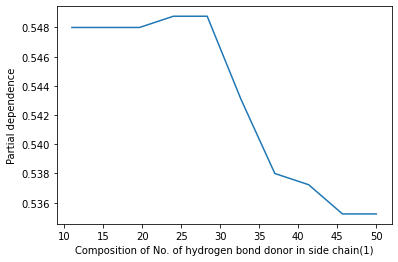

In [32]:
sns.lineplot(x=df_feature.iloc[:,0], y=df_partial_dependence.iloc[:,0])
plt.xlabel(df_feature.columns[0])
plt.ylabel("Partial dependence")

**Custom function for making PDP plots**

In [33]:
def plot_pdp(feature):
  pdp_plot = sns.lineplot(x=df_feature.iloc[:,feature], y=df_partial_dependence.iloc[:,feature])
  plt.xlabel(df_feature.iloc[:,feature].name)
  plt.ylabel("Partial dependence")
  return plt.show()

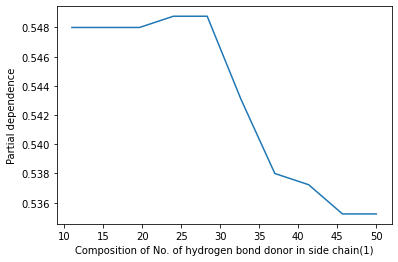

In [34]:
plot_pdp(0)

**From single run**

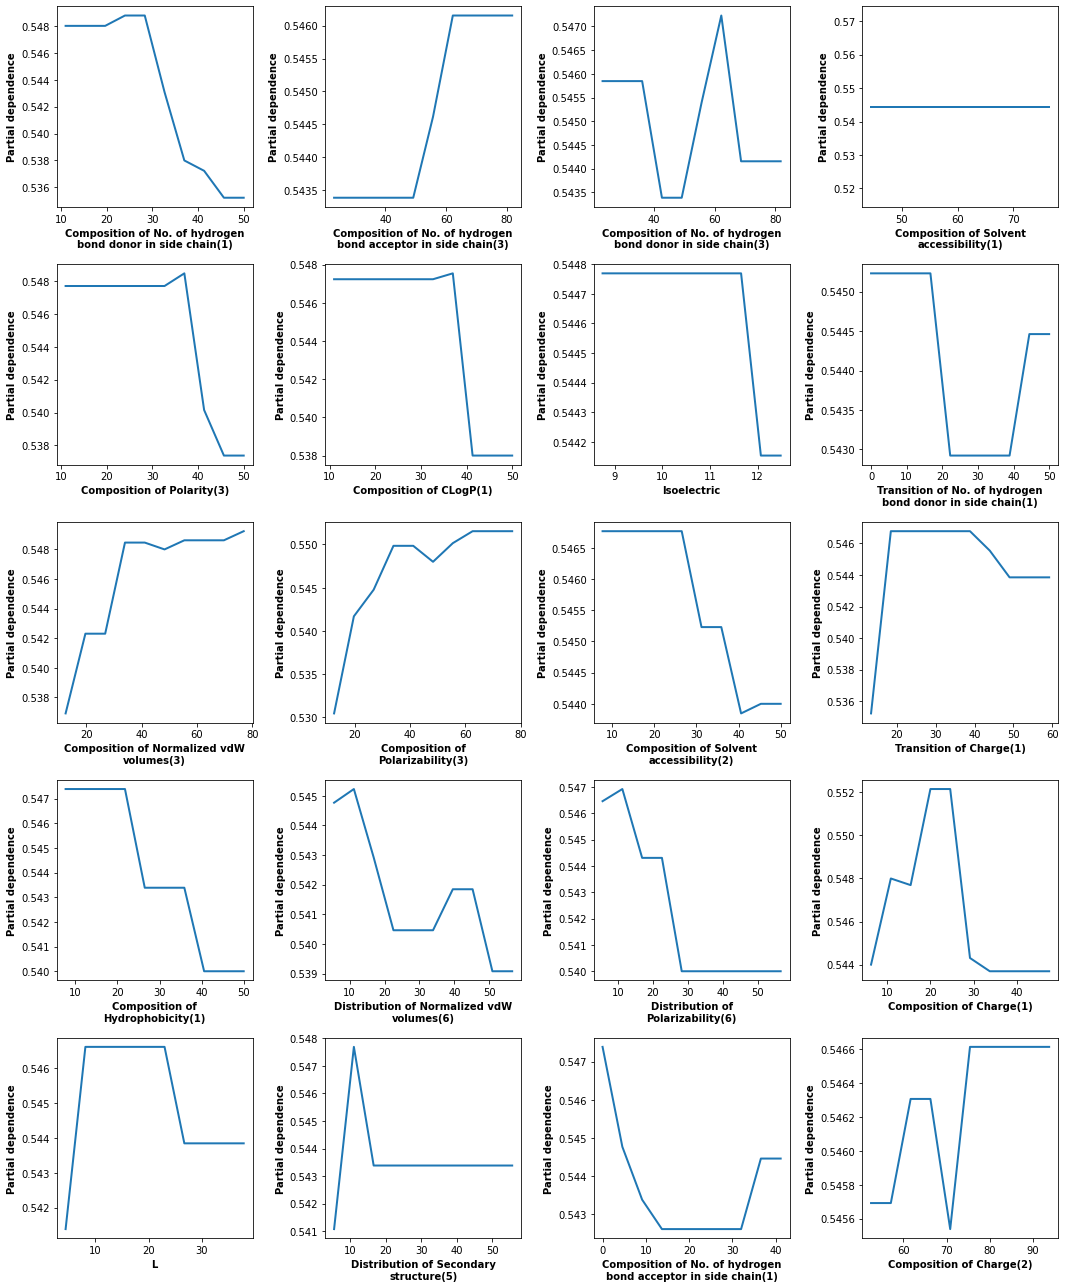

In [35]:
from textwrap import TextWrapper, dedent

#  plot Numerical Data
a = 5  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(15,18))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for feature in range(len(top20gini)):
    #plt.subplot(a, b, c)
    plt.subplot(a, b, c)
    #plt.title('{} (dist), subplot: {}{}{}'.format(i, a, b, c))

    sample_text = df_feature.iloc[:,feature].name
    wrapper = TextWrapper(width=30) 
    dedented_text = dedent(text=sample_text) 
    shortened_label = wrapper.fill(text=dedented_text)

    plt.xlabel( shortened_label, weight='bold')
    plt.ylabel("Partial dependence", weight='bold')
    sns.lineplot(x=df_feature.iloc[:,feature], y=df_partial_dependence.iloc[:,feature], linewidth = 2)
    c = c + 1

plt.tight_layout()
plt.savefig('Yscrambling_Paeruginosa_PDP_singlerun_output.pdf')
plt.show()

**Using mean values from 25 runs**

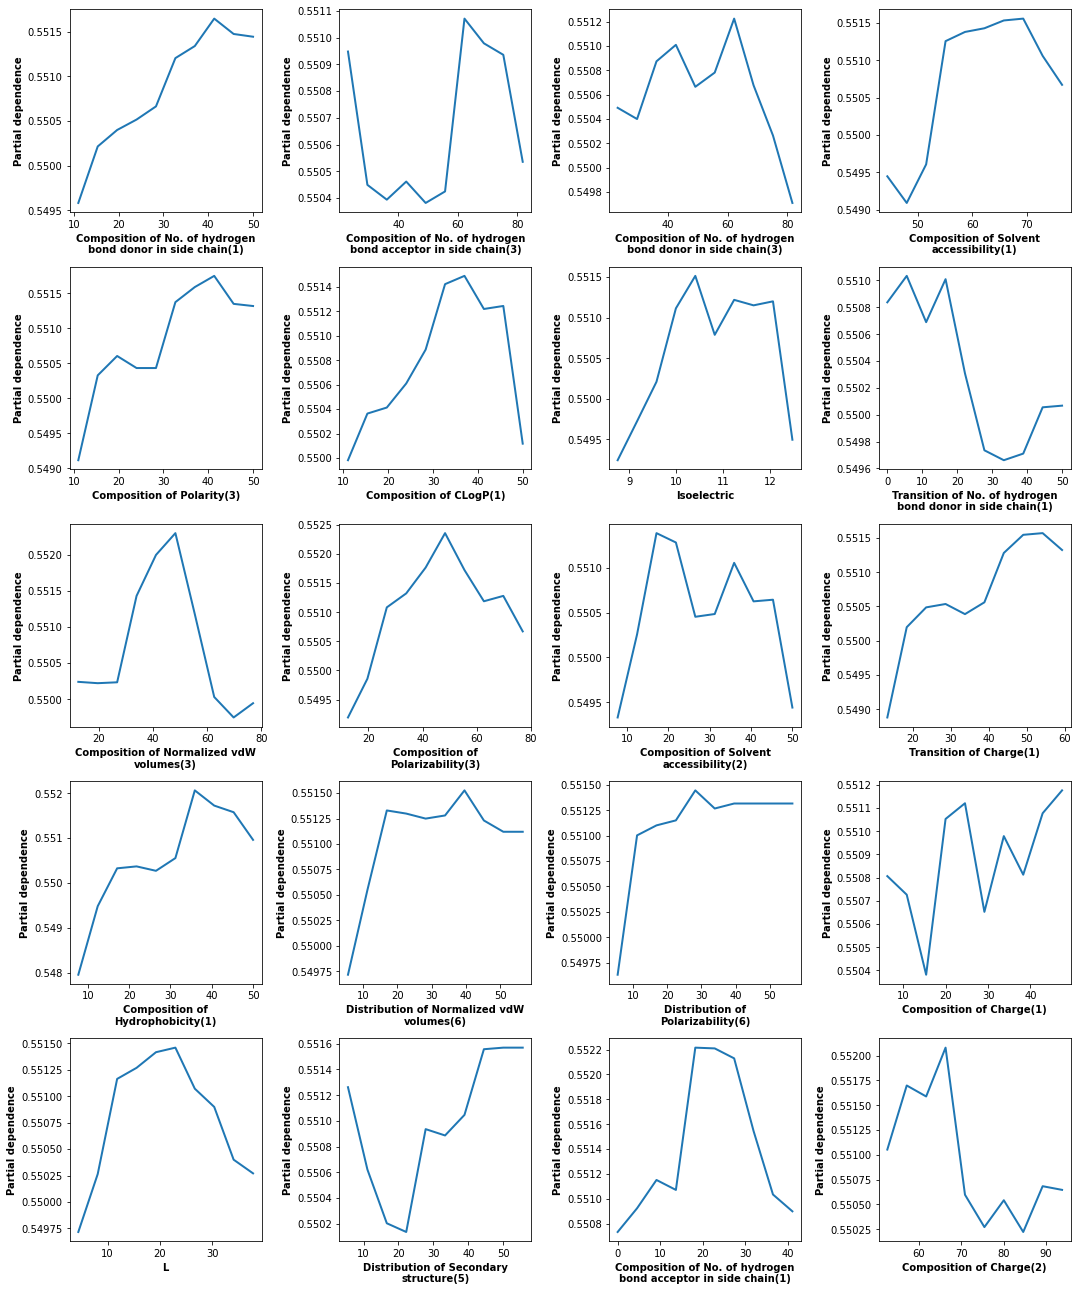

In [36]:
from textwrap import TextWrapper, dedent

#  plot Numerical Data
a = 5  # number of rows
b = 4  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(15,18))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for feature in range(len(top20gini)):
    #plt.subplot(a, b, c)
    plt.subplot(a, b, c)
    #plt.title('{} (dist), subplot: {}{}{}'.format(i, a, b, c))

    sample_text = df_feature.iloc[:,feature].name
    wrapper = TextWrapper(width=30) 
    dedented_text = dedent(text=sample_text) 
    shortened_label = wrapper.fill(text=dedented_text)

    plt.xlabel( shortened_label, weight='bold')
    plt.ylabel("Partial dependence", weight='bold')
    sns.lineplot(x=X_mean.iloc[:,feature], y=Y_mean.iloc[:,feature], linewidth = 2)
    c = c + 1

plt.tight_layout()
plt.savefig('Yscrambling_Paeruginosa_PDP_25runs_output.pdf')
plt.show()

---